# Hi :)

----

# Import libraries

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from noise import pnoise2
import tensorflow as tf
from tensorflow.keras import layers, models

# Dataset

In [2]:
# Dataset configuration
IMG_SIZE= 256  # Image size
NUM_SAMPLES= 100  # Number of images
SAVE_PATH= "fake_dataset/"
os.makedirs(SAVE_PATH, exist_ok= True)

# Perlin noise generation function for simulating refractory tissue
def generate_perlin_noise(shape, scale= 10):
    noise= np.zeros(shape, dtype= np.float32)
    for i in range(shape[0]):
        for j in range(shape[1]):
            noise[i][j]= pnoise2(i / scale, j / scale, octaves= 6, persistence= 0.5, lacunarity= 2.0)
    noise= (noise - noise.min()) / (noise.max() - noise.min())  # Normalization
    return noise

# Creating the fake dataset
for i in range(NUM_SAMPLES):
    texture= generate_perlin_noise((IMG_SIZE, IMG_SIZE), scale= 20)
    thickness_map= np.random.uniform(0.2, 1.0, (IMG_SIZE, IMG_SIZE)) * texture  # Thickness map
    image= (texture * 255).astype(np.uint8)
    mask= (thickness_map * 255).astype(np.uint8)
    
    # Saving image and mask
    cv2.imwrite(f"{SAVE_PATH}/image_{i}.png", image)
    cv2.imwrite(f"{SAVE_PATH}/mask_{i}.png", mask)

Showing some samples

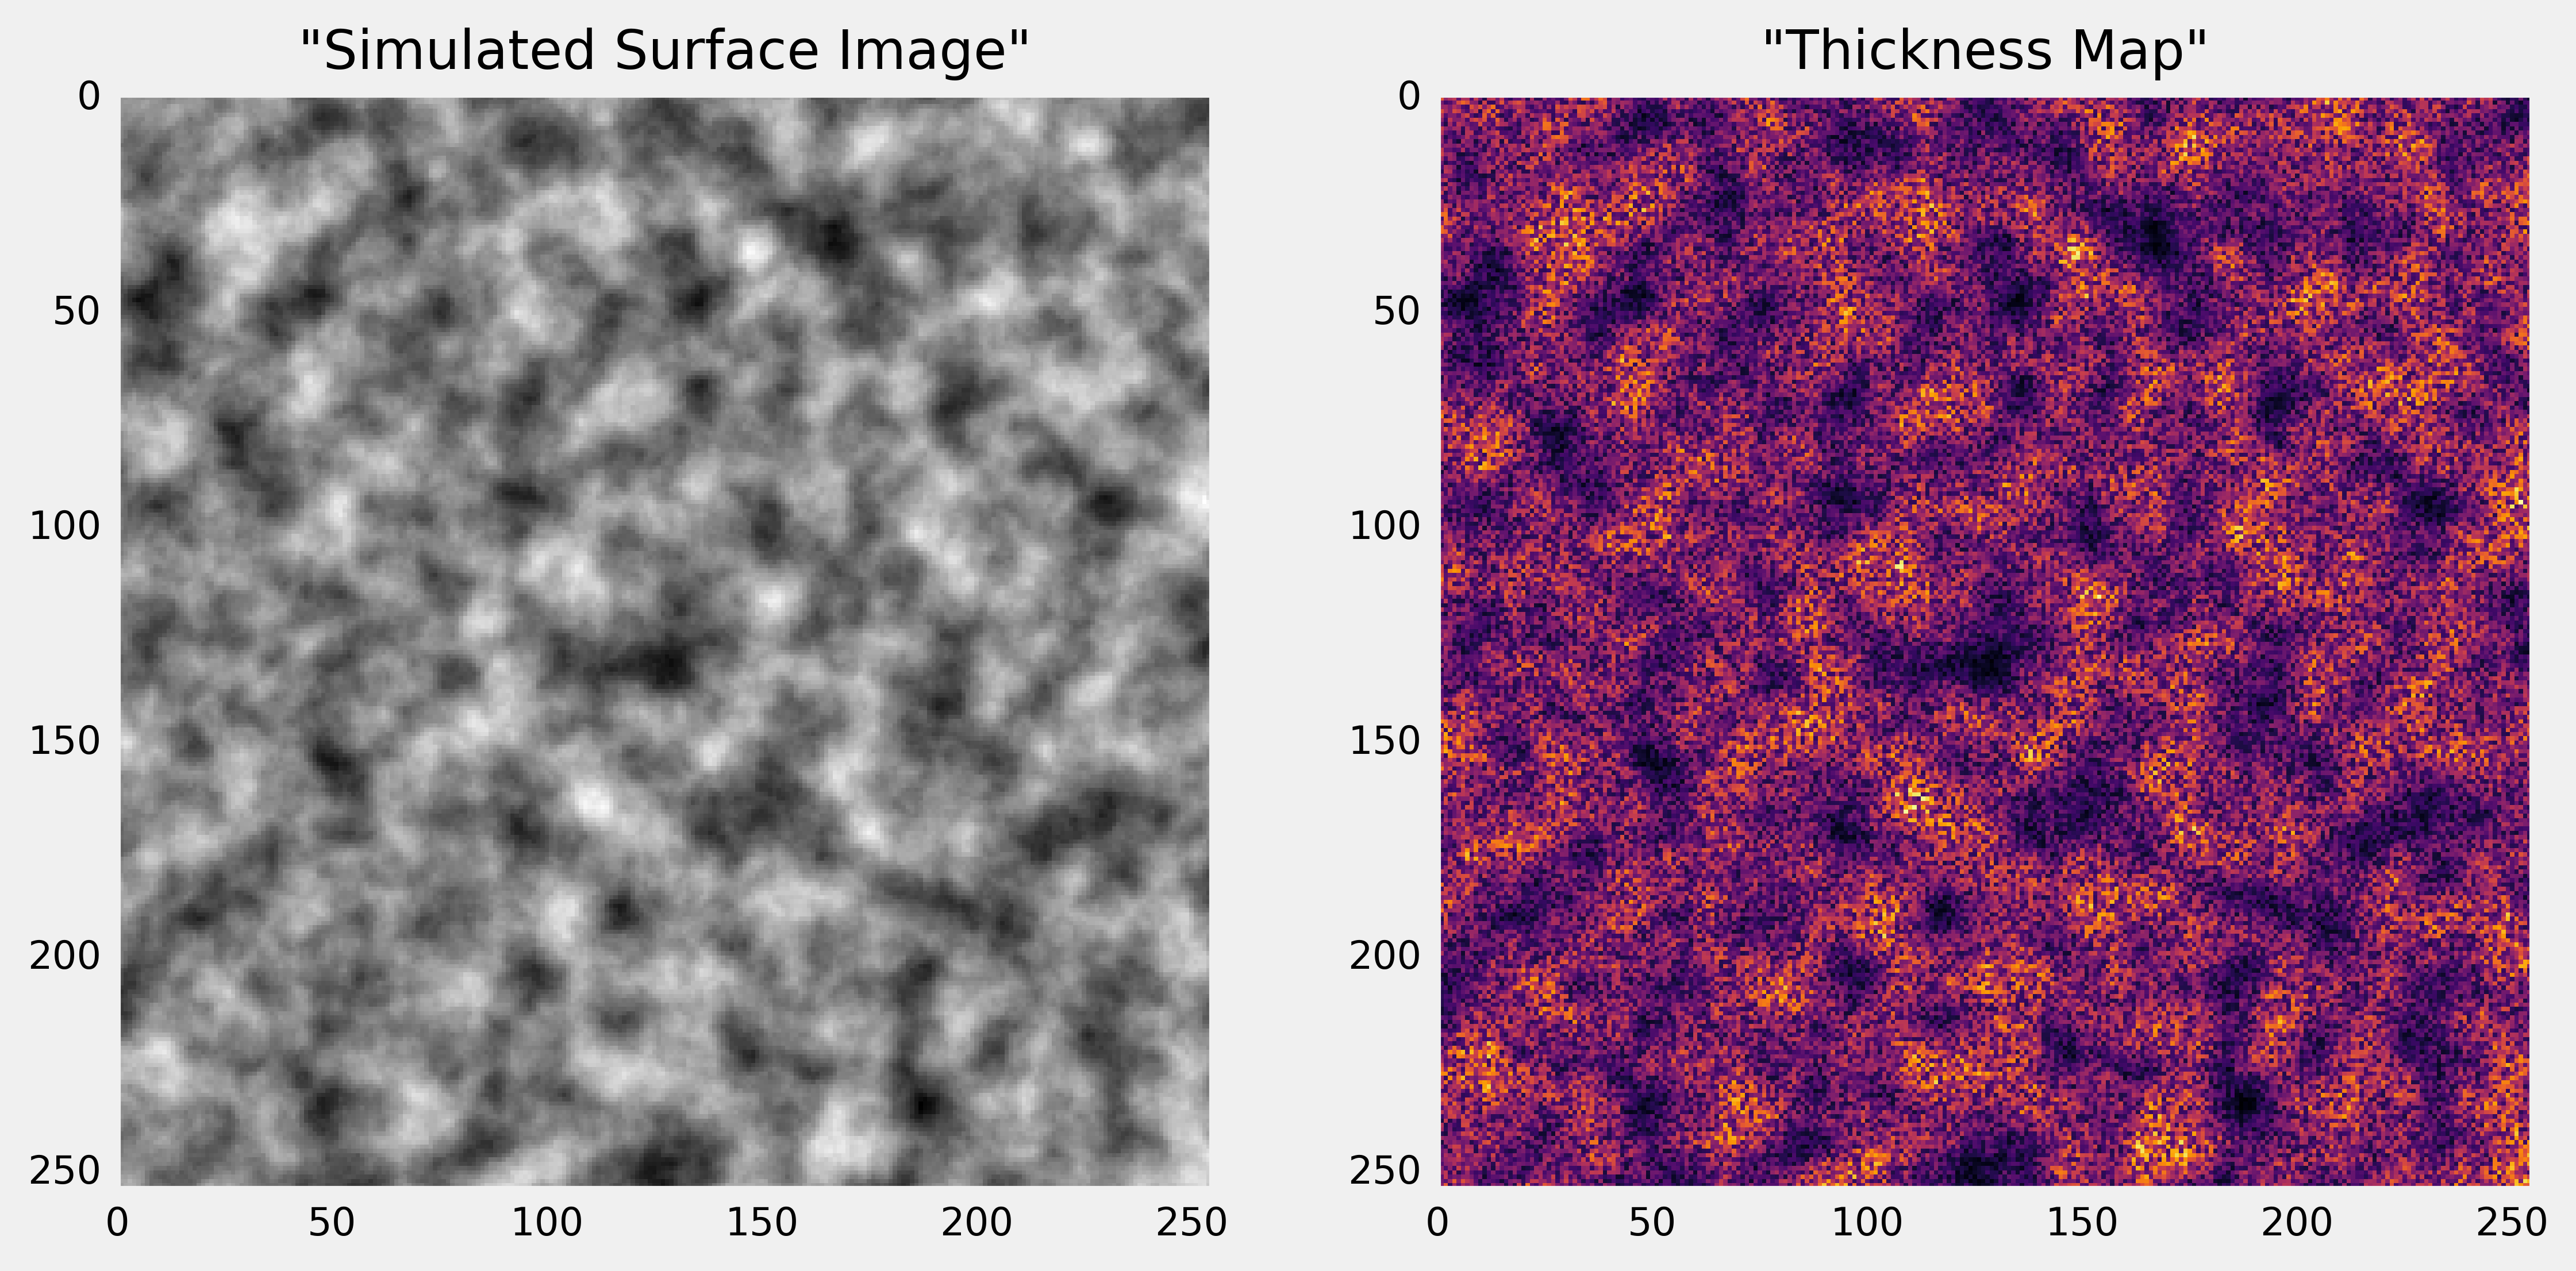

In [3]:
sample_img= cv2.imread(f"{SAVE_PATH}/image_0.png", cv2.IMREAD_GRAYSCALE)
sample_mask= cv2.imread(f"{SAVE_PATH}/mask_0.png", cv2.IMREAD_GRAYSCALE)

plt.style.use('fivethirtyeight')
plt.figure(figsize= (10,5), dpi= 484)
plt.subplot(1,2,1)
plt.title('"Simulated Surface Image"', fontsize= 14)
plt.xticks(fontsize= 10)
plt.yticks(fontsize= 10)
plt.imshow(sample_img, cmap= 'gray')
plt.grid(False)
plt.subplot(1,2,2)
plt.title('"Thickness Map"', fontsize= 14)
plt.xticks(fontsize= 10)
plt.yticks(fontsize= 10)
plt.imshow(sample_mask, cmap= 'inferno')
plt.grid(False)
plt.show()

# Model

Loading the dataset

In [4]:
DATASET_PATH= "fake_dataset/"
def load_data():
    images, masks= [], []
    for i in range(NUM_SAMPLES):
        img= cv2.imread(f"{DATASET_PATH}/image_{i}.png", cv2.IMREAD_GRAYSCALE)
        mask= cv2.imread(f"{DATASET_PATH}/mask_{i}.png", cv2.IMREAD_GRAYSCALE)
        img= cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0  # Normalization
        mask= cv2.resize(mask, (IMG_SIZE, IMG_SIZE)) / 255.0
        images.append(img)
        masks.append(mask)
    return np.array(images).reshape(-1, IMG_SIZE, IMG_SIZE, 1), np.array(masks).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

X, Y= load_data()
print("Dataset Loaded: ", X.shape, Y.shape)

Dataset Loaded:  (100, 256, 256, 1) (100, 256, 256, 1)


Creating UNet model

In [5]:
def unet():
    inputs= layers.Input((IMG_SIZE, IMG_SIZE, 1))
    # Downsampling
    c1= layers.Conv2D(64, (3,3), activation= 'relu', padding= 'same')(inputs)
    c1= layers.Conv2D(64, (3,3), activation= 'relu', padding= 'same')(c1)
    p1= layers.MaxPooling2D((2,2))(c1)
    
    c2= layers.Conv2D(128, (3,3), activation= 'relu', padding= 'same')(p1)
    c2= layers.Conv2D(128, (3,3), activation= 'relu', padding= 'same')(c2)
    p2= layers.MaxPooling2D((2,2))(c2)
    
    c3= layers.Conv2D(256, (3,3), activation= 'relu', padding= 'same')(p2)
    c3= layers.Conv2D(256, (3,3), activation= 'relu', padding= 'same')(c3)
    p3= layers.MaxPooling2D((2,2))(c3)
    
    # Bottleneck
    c4= layers.Conv2D(512, (3,3), activation= 'relu', padding= 'same')(p3)
    c4= layers.Conv2D(512, (3,3), activation= 'relu', padding= 'same')(c4)
    
    # Upsampling
    u1= layers.UpSampling2D((2,2))(c4)
    u1= layers.concatenate([u1, c3])
    c5= layers.Conv2D(256, (3,3), activation= 'relu', padding= 'same')(u1)
    c5= layers.Conv2D(256, (3,3), activation= 'relu', padding= 'same')(c5)
    
    u2= layers.UpSampling2D((2,2))(c5)
    u2= layers.concatenate([u2, c2])
    c6= layers.Conv2D(128, (3,3), activation= 'relu', padding= 'same')(u2)
    c6= layers.Conv2D(128, (3,3), activation= 'relu', padding= 'same')(c6)
    
    u3= layers.UpSampling2D((2,2))(c6)
    u3= layers.concatenate([u3, c1])
    c7= layers.Conv2D(64, (3,3), activation= 'relu', padding= 'same')(u3)
    c7= layers.Conv2D(64, (3,3), activation= 'relu', padding= 'same')(c7)
    
    outputs= layers.Conv2D(1, (1,1), activation= 'sigmoid')(c7)
    
    model= models.Model(inputs, outputs)
    model.compile(optimizer= 'adam', loss= 'binary_crossentropy', metrics= ['accuracy'])
    return model

model= unet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_9[0][0]  

 Total params: 7,781,761 (29.69 MB)

 Trainable params: 7,781,761 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

Train

In [6]:
model.fit(X, Y, epochs= 10, batch_size= 5, validation_split= 0.1)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 557s 28s/step - accuracy: 1.7414e-05 - loss: 0.9076 - val_accuracy: 2.2888e-05 - val_loss: 0.6330
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 518s 26s/step - accuracy: 2.2029e-05 - loss: 0.6291 - val_accuracy: 2.2888e-05 - val_loss: 0.6127
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 476s 27s/step - accuracy: 2.0526e-05 - loss: 0.6085 - val_accuracy: 2.2888e-05 - val_loss: 0.6013
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 478s 26s/step - accuracy: 2.2111e-05 - loss: 0.6013 - val_accuracy: 2.2888e-05 - val_loss: 0.5999
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 451s 25s/step - accuracy: 2.0658e-05 - loss: 0.5999 - val_accuracy: 2.2888e-05 - val_loss: 0.5992
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 454s 25s/step - accuracy: 2.0474e-05 - loss: 0.5993 - val_accuracy: 2.2888e-05 - val_loss: 0.5988
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 463s 26s/step - accuracy: 2.2663e-05 - loss: 0.5990 - val_accuracy: 2.2888e-05 - val_loss: 0.5986
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 511s 26s/s

Test

In [7]:
sample_idx= np.random.randint(0, NUM_SAMPLES)
prediction= model.predict(X[sample_idx : sample_idx + 1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


Visualization

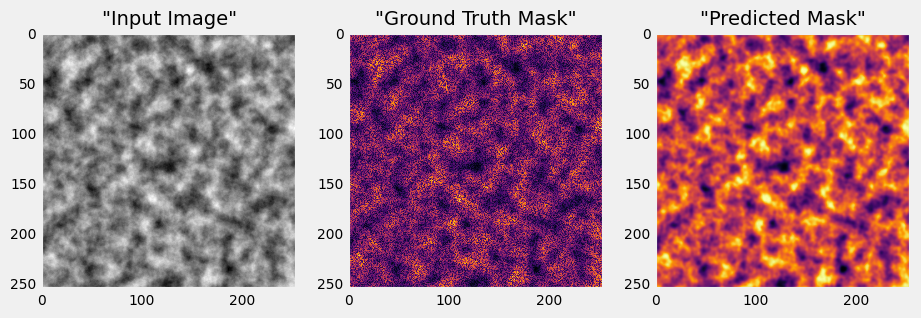

In [9]:
plt.style.use('fivethirtyeight')

plt.figure(figsize= (10,5))
plt.subplot(1,3,1)
plt.title('"Input Image"', fontsize= 14)
plt.xticks(fontsize= 10)
plt.yticks(fontsize= 10)
plt.grid(False)
plt.imshow(X[sample_idx].reshape(IMG_SIZE, IMG_SIZE), cmap= 'gray')

plt.subplot(1,3,2)
plt.title('"Ground Truth Mask"', fontsize= 14)
plt.xticks(fontsize= 10)
plt.yticks(fontsize= 10)
plt.grid(False)
plt.imshow(Y[sample_idx].reshape(IMG_SIZE, IMG_SIZE), cmap= 'inferno')

plt.subplot(1,3,3)
plt.title('"Predicted Mask"', fontsize= 14)
plt.xticks(fontsize= 10)
plt.yticks(fontsize= 10)
plt.grid(False)
plt.imshow(prediction[0].reshape(IMG_SIZE, IMG_SIZE), cmap= 'inferno')

plt.show()